## --- Generate text with a recurrent neural network (Pytorch) ---
### (Mostly Read & Run)

The goal is to replicate the (famous) experiment from [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

To learn to generate text, we train a recurrent neural network to do the following task:

Given a "chunk" of text: `this is random text`

the goal of the network is to predict each character in **`his is random text` ** sequentially given the following sequential input **`this is random tex`**:




## Load text (dataset/input.txt)

Before building training batch, we load the full text in RAM

In [1]:
!wget https://thome.isir.upmc.fr/classes/RITAL/input.txt

--2024-02-25 05:37:27--  https://thome.isir.upmc.fr/classes/RITAL/input.txt
Resolving thome.isir.upmc.fr (thome.isir.upmc.fr)... 134.157.18.247
Connecting to thome.isir.upmc.fr (thome.isir.upmc.fr)|134.157.18.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  2.08MB/s    in 0.5s    

2024-02-25 05:37:28 (2.08 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
! pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.2 MB/s eta 0:00:00


In [3]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('./input.txt').read()) #clean text => only ascii
file_len = len(file)
print(f'file_len = {file_len} caracteres')


file_len = 1115394 caracteres


## 2: Helper functions:

We have a text and we want to feed batch of chunks to a neural network:

one chunk  A,B,C,D,E
[input] A,B,C,D -> B,C,D,E [output]

Note: we will use an embedding layer instead of a one-hot encoding scheme.

for this, we have 3 functions:

- One to get a random str chunk of size `chunk_len` : `random_chunk`
- One to turn a chunk into a tensor of size `(1,chunk_len)` coding for each characters : `char_tensor`
- One to return random input and output chunks of size `(batch_size,chunk_len)` : `random_training_set`




In [4]:
import time, math


#Get a piece of text
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len) # chunk_len=la taille de la liste de chaine de caractere dont on veut prédire
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]


# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(1,len(string)).long()
    for c in range(len(string)):
        tensor[0,c] = all_characters.index(string[c])
    return tensor


#Turn a piece of text in train/test
def random_training_set(chunk_len=200, batch_size=8):
    chunks = [random_chunk(chunk_len) for _ in range(batch_size)]
    inp = torch.cat([char_tensor(chunk[:-1]) for chunk in chunks],dim=0)
    target = torch.cat([char_tensor(chunk[1:]) for chunk in chunks],dim=0)

    return inp, target

print(random_training_set(10,4))  ## should return 8 chunks of 10 letters. ## // E*19

(tensor([[14, 73, 94, 21, 14, 29, 94, 22, 14, 94],
        [96, 51, 50, 48, 51, 40, 60, 77, 96, 51],
        [30, 29, 94, 32, 17, 14, 29, 17, 14, 27],
        [13, 28, 94, 22, 18, 28, 29, 27, 30, 28]]), tensor([[73, 94, 21, 14, 29, 94, 22, 14, 94, 17],
        [51, 50, 48, 51, 40, 60, 77, 96, 51, 27],
        [29, 94, 32, 17, 14, 29, 17, 14, 27, 94],
        [28, 94, 22, 18, 28, 29, 27, 30, 28, 29]]))


## The actual RNN model (only thing to complete):

It should be composed of three distinct modules:

- an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) (n_characters, hidden_size)

```
nn.Embedding(len_dic,size_vec)
```
- a [recurrent](https://pytorch.org/docs/stable/nn.html#recurrent-layers) layer (hidden_size, hidden_size)
```
nn.RNN(in_size,out_size) or nn.GRU() or nn.LSTM() => rnn_cell parameter
```
- a [prediction](https://pytorch.org/docs/stable/nn.html#linear) layer (hidden_size, output_size)

```
nn.Linear(in_size,out_size)
```
=> Complete the `init` function code

In [5]:
import torch.nn.functional as f

class RNN(nn.Module):

    def __init__(self, n_char, hidden_size, output_size,rnn_cell=nn.RNN):
        """
        Create the network
        """
        super(RNN, self).__init__()

        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size

        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)
        # batch = taille du mini batch
        self.embed = nn.Embedding(n_char, hidden_size)

        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)
        self.rnn = rnn_cell(hidden_size, hidden_size)

        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)
        self.predict = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        """
        input est un batch de données. Matrice de taille N = taille_du_batch (combien de chunk/exemples), nb_caracteres, taille de l'embedding
        batched forward: input is (batch > 1,chunk_len)
        """
        input = self.embed(input)
        output,_  = self.rnn(input) #RNN retourne le ht
        output = self.predict(f.tanh(output))
        # On ecrit pas le softmax car le cross entropy de pytorch inclut le softmax, donc on lui passe la prédiction linéaire sans softmax
        return output

    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.rnn(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden


## Text generation function

Sample text from the model

In [6]:
def generate(model, prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_tensor(prime_str).squeeze(0)
    prime_input = prime_input.to(device)
    hidden = None
    predicted = prime_str+""
    # Use priming string to "build up" hidden state

    for p in range(len(prime_str)-1):
        _,hidden = model.forward_seq(prime_input[p].unsqueeze(0),hidden)


    for p in range(predict_len):
        output, hidden = model.forward_seq(prime_input[-1].unsqueeze(0), hidden)
                # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()

        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char

        charTensor = char_tensor(predicted_char).squeeze(0)
        charTensor = charTensor.to(device)
        prime_input = torch.cat([prime_input, charTensor])

    return predicted



## Training loop for net

In [33]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 20000 #ici c'est pas les epoques mais nb iterations d'apprentissage
print_every = 100
plot_every = 10
hidden_size = 100  #Taille de la couche cachée
lr = 0.005
batch_size = 16
chunk_len = 80  #Pour une suite de 80 caracteres, on va prédire le caractere suivant

####

## Est-ce qu'un GPU est disponible ?
use_cuda = torch.cuda.is_available()
## Si oui, on le définit comme device
device = torch.device("cuda" if use_cuda else "cpu")



model = RNN(n_characters, hidden_size, n_characters) #create model
model.to(device)
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad()

    # predict output
    output = model(inp)

    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1))

    #compute gradients and backpropagate
    loss.backward()
    model_optimizer.step()

    return loss.data.item()



for epoch in range(1, n_epochs + 1):
    training_set = random_training_set(chunk_len,batch_size)
    input, output = training_set[0].to(device), training_set[1].to(device)

    loss = train(input, output)  #train on one chunk
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')



    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 2s (100 0%) 2.4810]
Wh myanom Tu han lou
Porears tout hil esher ar lld ame aprend be has ave ar tail athet hbu ouens t tan 

 4s (200 1%) 2.5139]
Wh I an, M:

ISoore mat tef ave ndoout wiondeenu w, mare owin in be,


ABORL:
GEWang ber bome walin.
I 

 6s (300 1%) 2.4640]
Wheaisht nthine mire out gh O iverd t epinagheand is ourethand cerpandonthe ithare bur the in O s ce w 

 9s (400 2%) 2.4397]
Wh we d hat r bl is he my s nd t!
ARS:
RD f as s, as ffo th ithou INTote nd burs he tyothe int ber too 

 11s (500 2%) 2.5135]
Whe whoof I rtendes or nghind st we whindreere ngestou wobeit wild rrd; st he herean mesent thenditwre 

 13s (600 3%) 2.4788]
Wh be h osht pr ancelly oreats melesthe he coritherg ty nghisth will rrord tst.
's ded dan ar.

The wl 

 15s (700 3%) 2.4602]
Why in. ilare?
Yo ais me te, ceeard s
I:

RIN f is;
I'dy foure, ke knt trd loforaser br ss ie herer we 

 17s (800 4%) 2.4354]
Whare wind mecot sthrelontieard ma y wate,
Pe mbe sh t hith s,
He t cor hiverak, inor cins pa

## Visualize loss

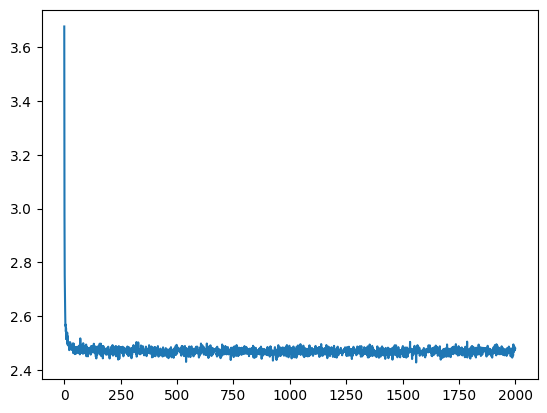

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Try different temperatures

Changing the distribution sharpness has an impact on character sampling:

more or less probable things are sampled

In [ ]:
print(generate(model,'T', 200, temperature=1))
print("----")
print(generate(model,'Th', 200, temperature=0.8))
print("----")

print(generate(model,'Th', 200, temperature=0.5))
print("----")

print(generate(model,'Th', 200, temperature=0.3))
print("----")

print(generate(model,'Th', 200, temperature=0.1)) # T tres bas --> deterministe

The aifow bad n tharlow, s my?
MIndarf y: lowaraninslerely,
DWhamy S: llltonor LETh man EE:

IO:

VInt Pr fomere p tioch asthate't,
I I seldy a bepo orthincr st, ICERLeerend
TEtly my and byot bicoth do
----
Thomedoure helounone touthedy anese s h cas, thin walath Par lief y onge, wicy II t l s himyoou PShyope I ghar is gh mire ce the ithis sank the.
PAn t ofen, ck.
The thr LELARI th toprt ce pillel hethise
----
Thane me wind t thowil tor t at it meree be the inde chare the thathe arer or theng anowe s timerend the te and t ave t ar an thind an pan the fe tr as MENG o ther the, bllllle tor thes s tound atharoue
----
The t me and t the the the thand f the he the t the an t t man me t my t tour the te the the t se and the the t t ing t the t wind t d t the the the t meand the that the s t mar t t the the thand t the 
----
The the the the the the the t the t the t t the the the the t the t the the the the the the t the the the t t t the t the the the t the the the t the t t t the the the t

### Improving this code:

(a) Tinker with parameters:

- Is it really necessary to have 100 dims character embeddings
- Chunk length can be gradually increased
- Try changing RNN cell type (GRUs - LSTMs)

(b) Add GPU support to go faster


## Modification des parametres

In [24]:
###Parameters
n_epochs = 20000 #ici c'est pas les epoques mais nb iterations d'apprentissage
print_every = 100
plot_every = 10
hidden_size = 512 #Taille de la couche cachée
lr = 0.005
batch_size = 64
chunk_len = 200 #Pour une suite de 80 caracteres, on va prédire le caractere suivant

## Est-ce qu'un GPU est disponible ?
use_cuda = torch.cuda.is_available()
## Si oui, on le définit comme device
device = torch.device("cuda" if use_cuda else "cpu")


####

model = RNN(n_characters, hidden_size, n_characters) #create model
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
model.to(device)

criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0

random_training_set = random_training_set(chunk_len,batch_size)
inp_RNN, out_RNN = training_set[0].to(device), training_set[1].to(device)

for epoch in range(1, n_epochs + 1):
    loss = train(inp_RNN, out_RNN)  #train on one chunk *random_training_set(chunk_len,batch_size)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')



    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 2s (100 0%) 2.5418]
Whr;n  U Id eoieec l tn u c u
t
d  igoaoelees  oinyc sr ao aoeuaoai. wura rria:eu ohy salt,eesAt   ol  

 3s (200 1%) 1.4902]
Whrt ul nh wdt  s wt,e ee etWRNs naro o
 Lel 
  i
RWatm dwsj.e t
iigwe  lio
efckHiera
iy  e :nhptz
yn  

 5s (300 1%) 0.8274]
WhZ' thloi pItdaPOhsdiun
lf C
 ,a,tni guneh,he
ta :ot; Yhou  b
 fa
hh ken ulh ttotnsseeaYon eN r a
ay  

 7s (400 2%) 0.4868]
Whra adrnkH'te aoil rgi dthoo,aobi taoloLcdh dmoh v isihbt Gb haatam dtye
eu lpnuteaa,IuecAiatCSlneks
 

 9s (500 2%) 0.2788]
Whra : r curatc sr e . t, amUdlf olaohAtuo A ,iben ttdnornkhov 
onae;o d?A oAv ssymtt
B nk: u  geoyoos 

 11s (600 3%) 0.1709]
Whrr as tv,re
eaRarTt
e u  SobteioOettf  a gu zmGehyFehad h
,:e
whr n;dteig ,e, isRie  
 tnhZiepga dsy 

 13s (700 3%) 0.1157]
Whr,tonsenid ;  e nhEortm
l a ,eadlAa,rmu sr rdpuyo  h e ti
Ti  eins lhyo W aiorogye rtry . y  eudevai 

 14s (800 4%) 0.0868]
Whr t Sie aoi atu WSm o :no
narnaio!ta
ta e  gNon sem ehbt lrswpdooaEpan   yilie  teredrdtuo I

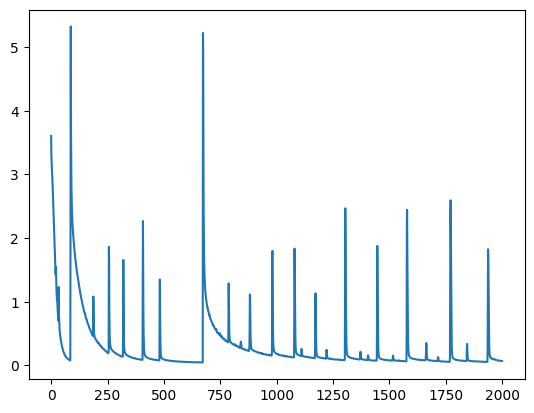

In [25]:
plt.figure()
plt.plot(all_losses)

## Modification du modele

LSTM

In [18]:
class LSTM(nn.Module):

    def __init__(self, n_char, hidden_size, output_size,lstm_cell=nn.LSTM):
        """
        Create the network
        """
        super(LSTM, self).__init__()

        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size

        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)
        # batch = taille du mini batch
        self.embed = nn.Embedding(n_char, hidden_size)

        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)
        self.lstm = lstm_cell(hidden_size, hidden_size)

        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)
        self.predict = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        """
        input est un batch de données. Matrice de taille N = taille_du_batch (combien de chunk/exemples), nb_caracteres, taille de l'embedding
        batched forward: input is (batch > 1,chunk_len)
        """
        input = self.embed(input)
        output,_  = self.lstm(input) #RNN retourne le ht
        output = self.predict(f.tanh(output))
        # On ecrit pas le softmax car le cross entropy de pytorch inclut le softmax, donc on lui passe la prédiction linéaire sans softmax
        return output

    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.lstm(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden

In [19]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 20000 #ici c'est pas les epoques mais nb iterations d'apprentissage
print_every = 100
plot_every = 10
hidden_size = 100  #Taille de la couche cachée
lr = 0.005
batch_size = 32
chunk_len = 100  #Pour une suite de 80 caracteres, on va prédire le caractere suivant

####

## Est-ce qu'un GPU est disponible ?
use_cuda = torch.cuda.is_available()
## Si oui, on le définit comme device
device = torch.device("cuda" if use_cuda else "cpu")


####

model = LSTM(n_characters, hidden_size, n_characters) #create model
model.to(device)

model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


training_set = random_training_set(chunk_len,batch_size)
inp_lstm, out_lstm = training_set[0].to(device), training_set[1].to(device)

for epoch in range(1, n_epochs + 1):
    loss = train(inp_lstm, out_lstm)  #train on one chunk
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')



    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 0s (100 0%) 2.4046]
Wh rol  luhvr lonl vodddaonrl;ht in daetldarnrshEoh bbat 
t runt
e
rsget;  Cfdnkt ytrgatrettrrWe
:hiai 

 0s (200 1%) 1.2625]
Wh reest hh stl  ir tiida alTga

hso oo oRhhmi  lpahhcAieHhu
g:hhm
vUn tYIpu:hh,r  uorwhlcaulahv ooRns 

 0s (300 1%) 0.5662]
Wh r edlrhhwo odd vflra
,s sfkeH 
 oynRtnrtwtettettettetttettseoe snrw th t if Meu y:haww    a al.hhmo 

 1s (400 2%) 0.2431]
Whwaaofdy:nAat  aoI  ua
i

 We I  ye ee e o oo ihil  ihss    hi so

sihd n Ddtdo arol alormrsuE
rte
rt 

 1s (500 2%) 0.1643]
Whe r l osihno lTin.rauEAosN  ttttt g -itCCCC itttttCCCC atttttrrdHkenuS hifl  oh easNf r,rllhhrNee sn 

 1s (600 3%) 0.1000]
Whdy'nta


snnuS w o
onTuTurlsN g ed sERhssg e
 sa s MeunD

 um
eeett   fordRsEChiiu
 sa a hiin iqiDdl 

 2s (700 3%) 0.0813]
Whe r sCCCnnfo ih ysidlo?lod ao aesN hhmoir eeetifdd  ysi

 ae, suau
hd soa

 sa a hi  thaody:he  esN  

 2s (800 4%) 0.0711]
Whrwtg ldldlodd sdaDwdn tttCCCCCCnldnoao c m
h:OHstnre:te s ;pm
rhsu tttro et h eNkeiiad ve   Lwe

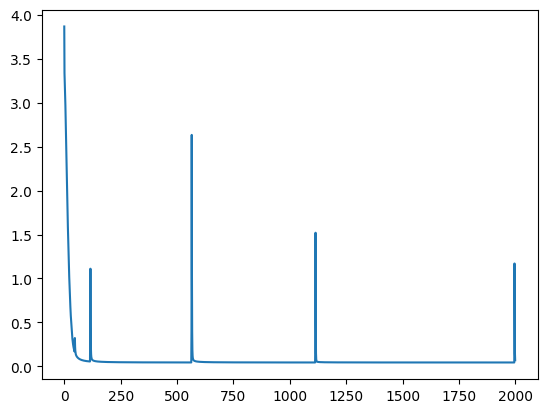

In [22]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(all_losses)